In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.stats as stats

import os
import xml.etree.ElementTree as ET
# from difflib import SequenceMatcher
import PyPDF2
from lxml import etree
# import Levenshtein

# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
import re

# Read papers CSVs

If there is **no** CSV with the downloaded files, use this:

In [44]:
directory = '../phys'
 
tei_files  = dict()
for filename in os.listdir(directory):
    fid = filename[:-6] # must get rid of version value and extensions
    fid.replace('_', '/')
    if fid not in tei_files:
        tei_files[fid] = 0
    tei_files[fid] = tei_files[fid] + 1
    
phys_papers = pd.read_csv('phys_papers.csv', low_memory=False).query('id in @tei_files').reset_index(drop = True)

If there is CSV:

In [183]:
cs_papers = pd.read_csv('../final_cs_papers.csv', dtype = {'id': str})

In [184]:
math_papers = pd.read_csv('../final_math_papers.csv', dtype = {'id': str})

# Functions

`get_pages_cnt`

In [174]:
def get_pages_cnt(papers, input_path):
    pages = []
    is_pdf = []

    for index, row in papers.iterrows():
        path = input_path + str(row.id).replace('/', '_') + 'v' + str(row.version) + '.pdf'
        file = open(path, 'rb')
        try:
            readpdf = PyPDF2.PdfFileReader(file, strict=False)
            pages.append(readpdf.numPages)
            is_pdf.append(True)
        except Exception as e:
            print(row.id, ' ', e)
            pages.append(np.nan)
            is_pdf.append(False)
    return pages, is_pdf

`get_xml_info`

In [181]:
def get_xml_info(papers, xml_path):
    namespace = "{http://www.tei-c.org/ns/1.0}"
    analytic_path = "./{0}teiHeader/{0}fileDesc/{0}sourceDesc/{0}biblStruct/{0}analytic".format(namespace)
    figures_path = "./{0}text/{0}body/{0}figure".format(namespace)
    
    ref_cnt = []
    authors_cnt = []
    figs_cnt = []
    titles = []
    grobid = []
    for index, row in papers.iterrows():        
        if not row.is_pdf:
            grobid.append(False)
            ref_cnt.append(np.nan)
            authors_cnt.append(np.nan)
            figs_cnt.append(np.nan)
            titles.append(row.title)
            continue
        try:
            tree = etree.parse(xml_path + str(row.id).replace('/', '_') + 'v' + str(row.version) + '.tei.xml')
            root = tree.getroot()
            
            grobid.append(True)
            
            e = root.find(analytic_path)
            authors = e.findall(".//{0}persName".format(namespace))
            ref = root.find(".//{0}listBibl".format(namespace))
            figs = root.findall(figures_path)
            title = root.find("./{0}teiHeader//{0}title".format(namespace))

            if ref is not None:
                ref_cnt.append(len(ref))
            else:
                ref_cnt.append(np.nan)

            if authors is not None:
                authors_cnt.append(len(authors))
            else:
                authors_cnt.append(np.nan)

            if figs is not None:
                figs_cnt.append(len(figs))
            else:
                figs_cnt.append(np.nan)

            if title is not None and title.text is not None:
                titles.append(title.text)
            else:
                titles.append(row.title)
                
        except Exception as e:
            ref_cnt.append(np.nan)
            authors_cnt.append(np.nan)
            figs_cnt.append(np.nan)
            titles.append(row.title)
            grobid.append(False)
        
    return grobid, ref_cnt, authors_cnt, figs_cnt, titles

`get_words_cnt`

In [93]:
def get_words_cnt(papers, xml_path):
    namespace = "{http://www.tei-c.org/ns/1.0}"
    
    words_cnt = []
    for index, row in papers.iterrows():        
        if (not row.is_pdf) or (not row.grobid):
            words_cnt.append(np.nan)
            continue
        
        tree = etree.parse(xml_path + str(row.id).replace('/', '_') + 'v' + str(row.version) + '.tei.xml')
        root = tree.getroot()
        curr_text = root.find("./{0}text".format(namespace))
        
        if curr_text is not None:
            text = str(etree.tostring(curr_text)).lower()
            words = re.findall('[A-Za-z]+', text)
            curr_dict = set(words)
            
            words_cnt.append(len(curr_dict))
        else:
            words_cnt.append(np.nan)
        
    return words_cnt

`get_text_modification`

In [95]:
def get_text_modification(papers, xml_path):
    namespace = "{http://www.tei-c.org/ns/1.0}"
    
    added_words_cnt = []
    removed_words_cnt = []
    for index, row in papers.iterrows():        
        if row.version == 1 or (not row.is_pdf) or (not row.grobid):
            added_words_cnt.append(np.nan)
            removed_words_cnt.append(np.nan)
            continue
    
        prev_vers = papers.loc[(papers.id == row.id) & (papers.version == row.version - 1)].iloc[0]
        if (not prev_vers.is_pdf) or (not prev_vers.grobid):
            added_words_cnt.append(np.nan)
            removed_words_cnt.append(np.nan)
            continue
        
        tree = etree.parse(xml_path + str(row.id).replace('/', '_') + 'v' + str(row.version) + '.tei.xml')
        root = tree.getroot()
        curr_text = root.find("./{0}text".format(namespace))
        
        tree = etree.parse(xml_path + str(row.id).replace('/', '_') + 'v' + str(row.version - 1) + '.tei.xml')
        root = tree.getroot()
        prev_text = root.find("./{0}text".format(namespace))
        
        if curr_text is not None and prev_text is not None:
            text = str(etree.tostring(curr_text)).lower()
            words = re.findall('[A-Za-z]+', text)
            curr_dict = set(words)
            
            text = str(etree.tostring(prev_text)).lower()
            words = re.findall('[A-Za-z]+', text)
            prev_dict = set(words)
            
            added_words_cnt.append(len(curr_dict.difference(prev_dict)))
            removed_words_cnt.append(len(prev_dict.difference(curr_dict)))
        else:
            added_words_cnt.append(np.nan)
            removed_words_cnt.append(np.nan)
        
    return added_words_cnt, removed_words_cnt

`get_delta_vals`

In [80]:
def get_delta_vals(papers):
    delta_ref_cnt = []
    delta_author_cnt = []
    delta_fig_cnt = []
    title_changed = []
    delta_pages = []
    for index, row in papers.iterrows():        
        if row.version == 1 or (not row.is_pdf) or (not row.grobid):
            delta_ref_cnt.append(np.nan)
            delta_author_cnt.append(np.nan)
            delta_fig_cnt.append(np.nan)
            title_changed.append(np.nan)
            delta_pages.append(np.nan)
            continue

        prev_ver = papers.loc[(papers.id == row.id) & (papers.version == row.version - 1)].iloc[0]
        if (not prev_ver.is_pdf) or (not prev_ver.grobid):
            delta_ref_cnt.append(np.nan)
            delta_author_cnt.append(np.nan)
            delta_fig_cnt.append(np.nan)
            title_changed.append(np.nan)
            delta_pages.append(np.nan)
            continue
            
        delta_ref_cnt.append(row.ref_cnt - prev_ver.ref_cnt)
        delta_author_cnt.append(row.authors_cnt - prev_ver.authors_cnt)
        delta_fig_cnt.append(row.figures_cnt - prev_ver.figures_cnt)
        title_changed.append(row.title != prev_ver.title)
        delta_pages.append(row.pages - prev_ver.pages)
        
    return delta_ref_cnt, delta_author_cnt, delta_fig_cnt, title_changed, delta_pages

In [190]:
import requests

url = 'https://arxiv.org/pdf/0704.0026v2.pdf'
r = requests.get(url, allow_redirects=False)

open('../math/0704.0026v2.pdf', 'wb').write(r.content)

176850

# Compute metrics

Get page counts and check if papers are valid PDFs:

In [56]:
(cs_papers['pages'], cs_papers['is_pdf']) = get_pages_cnt(cs_papers, '../cs/')

0704.1308   EOF marker not found
0707.1099   EOF marker not found
0802.2013   EOF marker not found
0805.1442   EOF marker not found
0807.2648   EOF marker not found
0809.0360   EOF marker not found
0812.2719   EOF marker not found
0901.3929   EOF marker not found
0902.3958   EOF marker not found
0907.3397   EOF marker not found
0908.2905   EOF marker not found
0908.2905   EOF marker not found
0909.3466   EOF marker not found
0910.2443   EOF marker not found
0910.2859   EOF marker not found
0911.1509   EOF marker not found
1001.5183   EOF marker not found
1002.2586   EOF marker not found
1002.3763   EOF marker not found
1003.0588   EOF marker not found
1004.4796   EOF marker not found
1006.3156   EOF marker not found
1007.1229   EOF marker not found
1007.3310   EOF marker not found
1007.4586   EOF marker not found
1009.2556   EOF marker not found
1009.3469   EOF marker not found
1009.5143   EOF marker not found
1010.1069   EOF marker not found
1010.5938   EOF marker not found
1011.3315 

incorrect startxref pointer(1)


1811.04270   EOF marker not found
1811.05056   EOF marker not found
1811.05965   EOF marker not found
1811.06471   EOF marker not found
1811.07698   EOF marker not found
1811.09231   EOF marker not found
1811.09317   EOF marker not found
1811.09393   EOF marker not found
1811.10827   EOF marker not found
1812.04994   EOF marker not found
1812.06325   EOF marker not found
1812.08305   EOF marker not found
1812.09526   EOF marker not found
1812.11481   EOF marker not found
1901.07223   EOF marker not found
1902.02009   EOF marker not found
1902.03855   EOF marker not found
1902.08093   EOF marker not found
1902.09278   EOF marker not found
1902.09334   EOF marker not found
1903.01189   EOF marker not found
1903.01463   EOF marker not found
1903.04240   EOF marker not found
1903.04240   EOF marker not found
1903.04421   EOF marker not found
1903.05297   EOF marker not found
1903.09556   EOF marker not found
1903.09556   EOF marker not found
1904.02361   EOF marker not found
1904.03139   E

Multiple definitions in dictionary at byte 0x3bcdd for key /Rotate
Multiple definitions in dictionary at byte 0x3cf69 for key /Rotate
Multiple definitions in dictionary at byte 0x3d029 for key /Rotate
Multiple definitions in dictionary at byte 0x3d0e9 for key /Rotate
Multiple definitions in dictionary at byte 0x3d1a9 for key /Rotate
Multiple definitions in dictionary at byte 0x3d269 for key /Rotate
Multiple definitions in dictionary at byte 0x3d329 for key /Rotate
Multiple definitions in dictionary at byte 0x3d495 for key /Rotate
Multiple definitions in dictionary at byte 0x3d555 for key /Rotate
Multiple definitions in dictionary at byte 0x3d615 for key /Rotate
Multiple definitions in dictionary at byte 0x3d6d5 for key /Rotate
Multiple definitions in dictionary at byte 0x3d795 for key /Rotate
Multiple definitions in dictionary at byte 0x3d855 for key /Rotate
Multiple definitions in dictionary at byte 0x3de66 for key /Rotate
Multiple definitions in dictionary at byte 0x3f1ce for key /Ro

1910.09258   EOF marker not found
1910.12256   EOF marker not found
1910.13166   EOF marker not found
1911.03744   EOF marker not found
1911.06647   EOF marker not found
1911.07959   EOF marker not found
1911.10088   EOF marker not found
1911.11170   EOF marker not found
1911.12411   EOF marker not found
1912.03558   EOF marker not found
1912.11110   EOF marker not found
1912.12912   EOF marker not found
2001.00218   EOF marker not found
2001.02612   EOF marker not found
2001.02612   EOF marker not found
2001.03166   EOF marker not found
2001.07754   EOF marker not found
2002.04833   EOF marker not found
2002.12349   EOF marker not found
2004.09776   EOF marker not found
2004.13018   EOF marker not found
2004.13117   EOF marker not found
2004.13254   EOF marker not found
2004.14665   EOF marker not found
2005.03333   EOF marker not found
2005.03341   EOF marker not found
2005.04975   EOF marker not found
2005.06557   EOF marker not found
2005.08767   EOF marker not found
2005.08944   E

Multiple definitions in dictionary at byte 0x5ea15 for key /Im142
Multiple definitions in dictionary at byte 0x7b4ab for key /Im186
Multiple definitions in dictionary at byte 0x7b4e7 for key /Im189
Multiple definitions in dictionary at byte 0x7b532 for key /Im185
Multiple definitions in dictionary at byte 0x5ea15 for key /Im142
Multiple definitions in dictionary at byte 0x7b4ab for key /Im186
Multiple definitions in dictionary at byte 0x7b4e7 for key /Im189
Multiple definitions in dictionary at byte 0x7b532 for key /Im185


2012.03312   EOF marker not found
2012.04982   EOF marker not found
2012.05122   EOF marker not found
2012.05122   EOF marker not found
2012.08020   EOF marker not found
2012.08180   EOF marker not found
2012.08418   EOF marker not found
2012.10820   EOF marker not found
2012.11619   EOF marker not found
2012.11747   EOF marker not found
2012.13682   EOF marker not found
2012.15455   EOF marker not found
2101.00311   EOF marker not found
2101.02188   EOF marker not found
2101.02463   EOF marker not found
2101.06553   EOF marker not found
2101.07217   EOF marker not found
2101.08200   EOF marker not found
2102.03117   EOF marker not found
2102.03542   EOF marker not found
2102.13367   EOF marker not found
2103.01286   EOF marker not found
2103.02167   EOF marker not found
2103.02167   EOF marker not found
2103.06720   EOF marker not found
2103.06720   EOF marker not found
2103.07894   EOF marker not found
2103.17081   EOF marker not found
2104.01958   EOF marker not found
2104.12335   E

Multiple definitions in dictionary at byte 0x1b46b for key /Rotate
Multiple definitions in dictionary at byte 0x1df7e for key /Rotate


2206.06847   EOF marker not found


In [192]:
(math_papers['pages'], math_papers['is_pdf']) = get_pages_cnt(math_papers, '../math/')

0704.0248   EOF marker not found
0704.1192   EOF marker not found
0704.2034   EOF marker not found
0704.2034   EOF marker not found
0704.2380   EOF marker not found
0704.3450   EOF marker not found
0704.3450   EOF marker not found
0704.3502   EOF marker not found
0705.0315   EOF marker not found
0705.0712   EOF marker not found
0705.3413   EOF marker not found
0705.3496   EOF marker not found
0706.1072   EOF marker not found
0706.1792   EOF marker not found
0706.2024   EOF marker not found
0707.1108   EOF marker not found
0707.1133   EOF marker not found
0707.1576   EOF marker not found
0707.1767   EOF marker not found
0707.2108   EOF marker not found
0707.2147   EOF marker not found
0707.3323   EOF marker not found
0707.4306   EOF marker not found
0708.0756   EOF marker not found
0708.2525   EOF marker not found
0708.3704   EOF marker not found
0709.0812   EOF marker not found
0709.2587   EOF marker not found
0709.4058   EOF marker not found
0709.4513   EOF marker not found
0710.0639 

Multiple definitions in dictionary at byte 0x3995e for key /Rotate
Multiple definitions in dictionary at byte 0x3c2ab for key /Rotate


1510.07503   EOF marker not found
1511.01939   EOF marker not found


Multiple definitions in dictionary at byte 0x26914 for key /Rotate
Multiple definitions in dictionary at byte 0x268f6 for key /Rotate


1511.02926   EOF marker not found
1511.07410   EOF marker not found
1511.08117   EOF marker not found
1511.08117   EOF marker not found
1511.08757   EOF marker not found
1511.09004   EOF marker not found
1511.09104   EOF marker not found
1512.02008   EOF marker not found
1512.02873   EOF marker not found
1512.04390   EOF marker not found
1512.05780   EOF marker not found
1512.07676   EOF marker not found
1601.00294   EOF marker not found
1601.02863   EOF marker not found
1601.02863   EOF marker not found
1601.04528   EOF marker not found
1601.07081   EOF marker not found
1601.07081   EOF marker not found
1602.02015   EOF marker not found
1602.02015   EOF marker not found
1602.04307   EOF marker not found
1602.04396   EOF marker not found
1602.05078   EOF marker not found
1602.05097   EOF marker not found
1602.05401   EOF marker not found
1602.06180   EOF marker not found
1602.08574   EOF marker not found
1602.08965   EOF marker not found
1603.03940   EOF marker not found
1603.04174   E

Multiple definitions in dictionary at byte 0x469ae for key /Rotate
Multiple definitions in dictionary at byte 0x46a68 for key /Rotate
Multiple definitions in dictionary at byte 0x46bd0 for key /Rotate
Multiple definitions in dictionary at byte 0x46a25 for key /Rotate
Multiple definitions in dictionary at byte 0x46adf for key /Rotate
Multiple definitions in dictionary at byte 0x46c47 for key /Rotate
Multiple definitions in dictionary at byte 0x46a80 for key /Rotate
Multiple definitions in dictionary at byte 0x46b3a for key /Rotate
Multiple definitions in dictionary at byte 0x46ca2 for key /Rotate


1610.00798   EOF marker not found
1610.01532   EOF marker not found
1610.01976   EOF marker not found
1610.02581   EOF marker not found
1610.04275   EOF marker not found
1610.04776   EOF marker not found
1610.06237   EOF marker not found
1610.06400   EOF marker not found
1610.06501   EOF marker not found
1610.06685   EOF marker not found
1610.07377   EOF marker not found
1610.07471   EOF marker not found
1610.08391   EOF marker not found
1611.02784   EOF marker not found
1611.03024   EOF marker not found
1611.03038   EOF marker not found
1611.03251   EOF marker not found
1611.05390   EOF marker not found
1611.05590   EOF marker not found
1611.06556   EOF marker not found
1611.06556   EOF marker not found
1611.08462   EOF marker not found
1611.09054   EOF marker not found
1611.09270   EOF marker not found
1611.09914   EOF marker not found
1611.09914   EOF marker not found
1611.10234   EOF marker not found
1612.02080   EOF marker not found
1612.02178   EOF marker not found
1701.01803   E

Multiple definitions in dictionary at byte 0x1038a for key /Rotate


1807.03363   EOF marker not found
1807.04079   EOF marker not found
1807.04079   EOF marker not found
1807.04318   EOF marker not found
1807.04399   EOF marker not found
1807.11165   EOF marker not found
1807.11165   EOF marker not found
1808.01073   EOF marker not found
1808.01416   EOF marker not found
1808.05598   EOF marker not found
1809.00602   EOF marker not found
1809.01340   EOF marker not found
1809.03123   EOF marker not found
1809.05226   EOF marker not found
1809.05765   EOF marker not found
1809.10063   EOF marker not found
1810.01528   EOF marker not found
1810.08969   EOF marker not found
1810.09950   EOF marker not found
1810.10574   EOF marker not found
1810.11799   EOF marker not found
1811.10015   EOF marker not found
1812.03362   EOF marker not found
1812.08271   EOF marker not found
1812.09752   EOF marker not found
1812.11491   EOF marker not found
1901.02673   EOF marker not found
1901.03087   EOF marker not found
1901.05940   EOF marker not found
1902.01141   E

Check if the paper were parsed by Grobid, get the title, reference counts, author counts, figures counts:

In [68]:
cs_papers['grobid'], cs_papers['ref_cnt'], cs_papers['authors_cnt'], cs_papers['figures_cnt'], cs_papers['title'] = get_xml_info(cs_papers, '../cs_tei/')

In [194]:
math_papers['grobid'], math_papers['ref_cnt'], math_papers['authors_cnt'], math_papers['figures_cnt'], math_papers['title'] = get_xml_info(math_papers, '../math_tei/')

Get differences between consecutive paper versions:

In [71]:
cs_papers['delta_ref_cnt'], cs_papers['delta_authors_cnt'], cs_papers['delta_figures_cnt'], cs_papers['title_changed'], cs_papers["delta_pages"] = get_delta_vals(cs_papers)

In [195]:
math_papers['delta_ref_cnt'], math_papers['delta_authors_cnt'], math_papers['delta_figures_cnt'], math_papers['title_changed'], math_papers["delta_pages"] = get_delta_vals(math_papers)

Compute the number of words in the paper text:

In [94]:
cs_papers['words_cnt'] = get_words_cnt(cs_papers, '../cs_tei/')

In [196]:
math_papers['words_cnt'] = get_words_cnt(math_papers, '../math_tei/')

Compute how many words are added/removed between to consecutive versions of a paper:

In [82]:
cs_papers['added_words_cnt'], cs_papers['removed_words_cnt'] = get_text_modification(cs_papers, '../cs_tei/')

In [197]:
math_papers['added_words_cnt'], math_papers['removed_words_cnt'] = get_text_modification(math_papers, '../math_tei/')

Reorder columns:

In [200]:
list(math_papers.columns.values)

['title',
 'id',
 'categories',
 'version',
 'total_versions',
 'date',
 'pages',
 'is_pdf',
 'grobid',
 'ref_cnt',
 'authors_cnt',
 'figures_cnt',
 'delta_ref_cnt',
 'delta_authors_cnt',
 'delta_figures_cnt',
 'title_changed',
 'delta_pages',
 'words_cnt',
 'added_words_cnt',
 'removed_words_cnt']

In [198]:
new_cols = ['title', 'id', 'categories', 'version', 'total_versions', 'date', 'is_pdf', 'grobid', 'pages', 'delta_pages', 'words_cnt', 'removed_words_cnt', 'added_words_cnt', 'ref_cnt', 'delta_ref_cnt', 'authors_cnt', 'delta_authors_cnt', 'figures_cnt', 'delta_figures_cnt', 'title_changed']

In [203]:
cs_papers = cs_papers[new_cols]

In [203]:
math_papers = math_papers[new_cols]

In [209]:
cs_papers.to_csv("analysed_cs_papers.csv", index=False)

In [209]:
math_papers.to_csv("analysed_math_papers.csv", index=False)

# Vsiualise data

In [210]:
cs_papers = pd.read_csv('analysed_cs_papers.csv', dtype = {'id': str})

In [211]:
cs_papers.head()

,title,id,categories,version,total_versions,date,is_pdf,grobid,pages,delta_pages,words_cnt,removed_words_cnt,added_words_cnt,ref_cnt,delta_ref_cnt,authors_cnt,delta_authors_cnt,figures_cnt,delta_figures_cnt,title_changed
0,Antenna Combining for the MIMO Downlink Channel,0704.1308,cs.IT math.IT,1,2,2007-04-10 20:56:14+00:00,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Antenna Combining for the MIMO Downlink Channel,0704.1308,cs.IT math.IT,2,2,2007-08-19 17:06:50+00:00,True,True,16.0,NaN,1063.0,NaN,NaN,18.0,NaN,1.0,NaN,7.0,NaN,NaN
2,Chrom ati cEdge Strength ofSom e M ul ti graphs,0706.3848,cs.DM,1,2,2007-06-26 14:43:15+00:00,True,True,7.0,NaN,780.0,NaN,NaN,0.0,NaN,0.0,NaN,5.0,NaN,NaN
3,Minimum Sum Edge Colorings of Multicycles,0706.3848,cs.DM,2,2,2008-01-22 13:36:41+00:00,True,True,13.0,6.0,844.0,536.0,600.0,23.0,23.0,3.0,3.0,4.0,-1.0,True
4,A Comparison of Push and Pull Techniques for Ajax,0706.3984,cs.SE cs.PF,1,2,2007-06-27 09:14:40+00:00,True,True,12.0,NaN,1264.0,NaN,NaN,24.0,NaN,3.0,NaN,6.0,NaN,NaN


In [204]:
math_papers.head()

,title,id,categories,version,total_versions,date,is_pdf,grobid,pages,delta_pages,words_cnt,removed_words_cnt,added_words_cnt,ref_cnt,delta_ref_cnt,authors_cnt,delta_authors_cnt,figures_cnt,delta_figures_cnt,title_changed
0,Sparsity-certifying Graph Decompositions,0704.0002,math.CO cs.CG,1,2,2007-03-31 02:26:18+00:00,True,True,23.0,NaN,981.0,NaN,NaN,25.0,NaN,2.0,NaN,11.0,NaN,NaN
1,Sparsity-certifying Graph Decompositions,0704.0002,math.CO cs.CG,2,2,2008-12-13 17:26:00+00:00,True,True,18.0,-5.0,1014.0,64.0,97.0,24.0,-1.0,2.0,0.0,10.0,-1.0,False
2,Computing genus 2 Hilbert-Siegel modular forms...,0704.0011,math.NT math.AG,1,3,2007-03-31 05:32:49+00:00,True,True,13.0,NaN,946.0,NaN,NaN,0.0,NaN,7.0,NaN,5.0,NaN,NaN
3,Computing genus 2 Hilbert-Siegel modular forms...,0704.0011,math.NT math.AG,2,3,2008-08-19 04:46:47+00:00,True,True,14.0,1.0,1045.0,81.0,180.0,0.0,0.0,5.0,-2.0,5.0,0.0,False
4,COMPUTING GENUS 2 HILBERT-SIEGEL MODULAR FORMS...,0704.0011,math.NT math.AG,3,3,2008-08-20 13:15:09+00:00,True,True,14.0,0.0,808.0,719.0,482.0,11.0,11.0,2.0,-3.0,3.0,-2.0,True


In [212]:
cs_papers.describe()

,version,total_versions,pages,delta_pages,words_cnt,removed_words_cnt,added_words_cnt,ref_cnt,delta_ref_cnt,authors_cnt,delta_authors_cnt,figures_cnt,delta_figures_cnt
count,9600.000000,9600.000000,9051.000000,4931.000000,9003.000000,4928.000000,4928.000000,9003.000000,4928.000000,9003.000000,4928.000000,9003.000000,4928.000000
mean,1.783229,2.566458,18.487128,0.908943,1335.284239,71.956169,120.441356,38.919693,2.278815,4.011218,0.096591,11.387426,0.695211
std,0.797557,0.715171,16.252562,6.421410,466.835890,124.530894,164.962958,27.674022,9.175453,7.734728,2.289749,11.063904,4.494369
min,1.000000,2.000000,2.000000,-194.000000,75.000000,0.000000,0.000000,0.000000,-176.000000,0.000000,-57.000000,0.000000,-71.000000
25%,1.000000,2.000000,10.000000,0.000000,1040.000000,3.000000,6.000000,23.000000,0.000000,2.000000,0.000000,6.000000,0.000000
50%,2.000000,2.000000,15.000000,0.000000,1291.000000,25.000000,56.000000,34.000000,0.000000,3.000000,0.000000,10.000000,0.000000
75%,2.000000,3.000000,23.000000,2.000000,1560.000000,87.000000,174.000000,48.000000,4.000000,5.000000,0.000000,15.000000,2.000000
max,4.000000,4.000000,382.000000,190.000000,5395.000000,2466.000000,1546.000000,416.000000,179.000000,324.000000,84.000000,521.000000,118.000000


In [205]:
math_papers.describe()

,version,total_versions,pages,delta_pages,words_cnt,removed_words_cnt,added_words_cnt,ref_cnt,delta_ref_cnt,authors_cnt,delta_authors_cnt,figures_cnt,delta_figures_cnt
count,9772.000000,9772.000000,8735.000000,4535.000000,8708.000000,4535.000000,4535.000000,8708.000000,4535.000000,8708.000000,4535.000000,8708.000000,4535.000000
mean,1.810172,2.620344,25.968060,1.112679,1022.867593,61.814112,100.003749,29.394120,2.648512,2.194189,0.044542,10.369201,0.600000
std,0.818054,0.735483,18.641282,5.259005,401.624249,155.258188,144.343720,22.602048,7.313777,1.441108,0.726492,9.089944,3.673496
min,1.000000,2.000000,1.000000,-76.000000,25.000000,0.000000,0.000000,0.000000,-43.000000,0.000000,-12.000000,0.000000,-28.000000
25%,1.000000,2.000000,15.000000,0.000000,746.000000,6.000000,16.000000,16.000000,0.000000,1.000000,0.000000,4.000000,-1.000000
50%,2.000000,2.000000,22.000000,0.000000,971.500000,21.000000,52.000000,25.000000,1.000000,2.000000,0.000000,8.000000,0.000000
75%,2.000000,3.000000,33.000000,2.000000,1248.000000,55.000000,126.000000,37.000000,4.000000,3.000000,0.000000,14.000000,2.000000
max,4.000000,4.000000,308.000000,124.000000,3767.000000,2528.000000,2178.000000,384.000000,122.000000,20.000000,16.000000,101.000000,39.000000


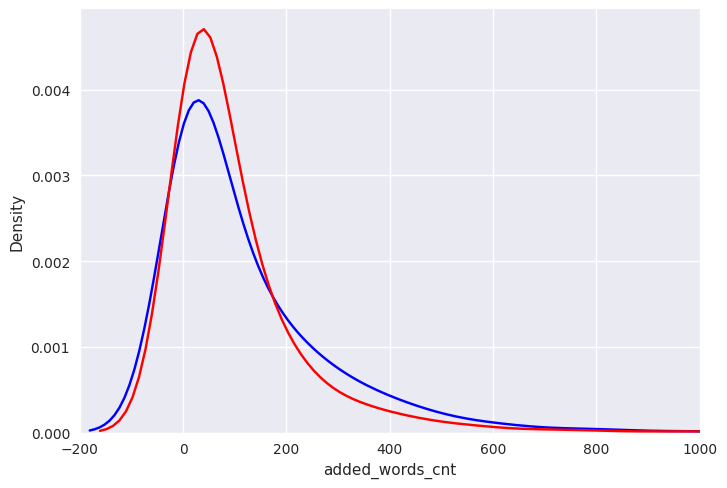

In [226]:
seaborn.kdeplot(data = cs_papers["added_words_cnt"], bw_adjust = 2, color='blue')
seaborn.kdeplot(data = math_papers["added_words_cnt"], bw_adjust = 2, color='red')
plt.xlim([-200, 1000])
plt.grid(True, alpha=1, linestyle="-")

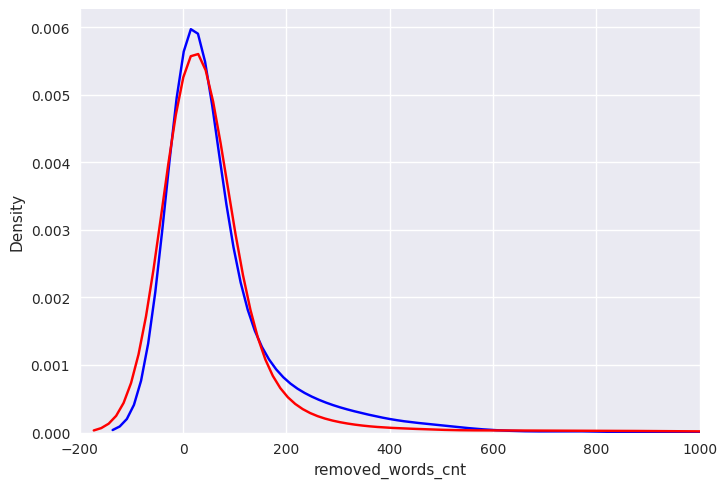

In [227]:
seaborn.kdeplot(data = cs_papers["removed_words_cnt"], bw_adjust = 2, color='blue')
seaborn.kdeplot(data = math_papers["removed_words_cnt"], bw_adjust = 2, color='red')
plt.xlim([-200, 1000])
plt.grid(True, alpha=1, linestyle="-")

(-30.0, 30.0)

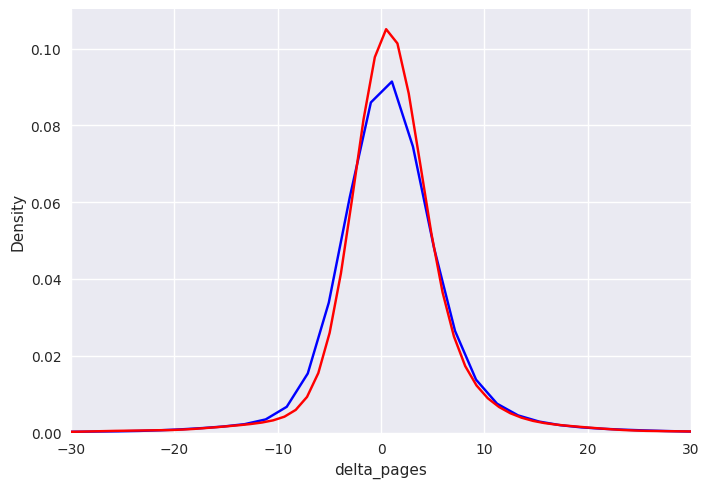

In [224]:
seaborn.kdeplot(data = cs_papers["delta_pages"], bw_adjust = 3, color='blue')
seaborn.kdeplot(data = math_papers["delta_pages"], bw_adjust = 3, color='red')

plt.xlim([-30, 30])

(-40.0, 40.0)

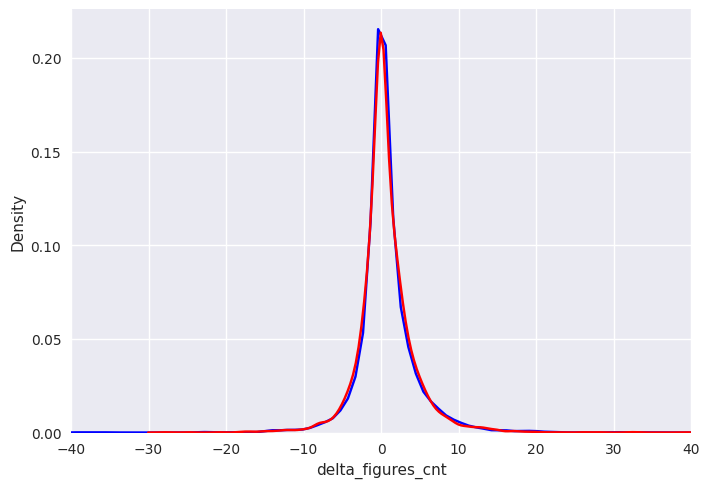

In [225]:
seaborn.kdeplot(data = cs_papers["delta_figures_cnt"], color='blue')
seaborn.kdeplot(data = math_papers["delta_figures_cnt"], color='red')
plt.xlim([-40, 40])

In [ ]:
cs_added = cs_papers.loc[cs_papers.delta_pages > 0].id.count()
cs_subtracted = cs_papers.loc[cs_papers.delta_pages < 0].id.count()
cs_same = cs_papers.loc[cs_papers.delta_pages == 0].id.count()

math_added = math_papers.loc[math_papers.delta_pages > 0].id.count()
math_subtracted = math_papers.loc[math_papers.delta_pages < 0].id.count()
math_same = math_papers.loc[math_papers.delta_pages == 0].id.count()

cs_diffs = [cs_same, cs_added, cs_subtracted]
math_diffs = [math_same, math_added, math_subtracted]
labels = ["No difference in page count", "Pages added", "Pages removed"]

def func(pct):
    return "{:1.1f}%".format(pct)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.pie(cs_diffs, autopct=lambda pct: func(pct), shadow=True)
plt.title('Difference in CS page count')

plt.subplot(1, 2, 2)
plt.pie(math_diffs, autopct=lambda pct: func(pct), shadow=True)
plt.title('Difference in Math page count')

plt.legend(labels, loc=4)
plt.show() 
